In [ ]:
#@title
import os
import datetime
import random
import itertools

import IPython
import IPython.display
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


from matplotlib import dates
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, \
 RepeatVector, Concatenate, Bidirectional, BatchNormalization, multiply, dot, GRU
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from scipy.fft import rfft, rfftfreq
from sklearn.metrics import  mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import boxcox

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def get_hdb(df):
    n = df.shape[0]
    hdb = np.zeros(n)
    for index_recover in range(n):
        for index_noticed in range(index_recover, 0, -1):
            if df['Выздоровевших и умерших'].iloc[index_recover]<=df['Выявлено всего'].iloc[index_noticed]:
                hdb[index_recover] = index_recover-index_noticed
    return hdb

mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False

seed = 0
seed_everything(seed)
df = pd.read_csv('data_yandex.csv', sep=";")
df.reset_index(drop=True, inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y-%m-%d %H:%M:%S")
df.rename(columns={'DateTime': 'Дата', 'Заражений': 'Выявлено всего'}, inplace=True)

df['% Выздоровлений'] = df['Выздоровлений'].pct_change()
df['% Смертей'] = df['Смертей'].pct_change()
df['% прирост'] = df['Выявлено всего'].pct_change()
df.rename(columns={'DateTime': 'Дата'}, inplace=True)
df['Выздоровевших и умерших'] = df['Выздоровлений'] + df['Смертей']
df['Выздоровевших и умерших'] = df['Выздоровевших и умерших']

df['Характерстика ДБ'] = get_hdb(df)

df = df[['Дата', 'Выявлено всего', 'Выздоровевших и умерших', 'Заражений за день', '% прирост', 'Выздоровлений', 'Выздоровлений за день', '% Выздоровлений', 'Смертей', 'Смертей за день', '% Смертей', 'Летальность, %', 'Характерстика ДБ']]

df = df.drop(index=df[df['% прирост']>1].index)
df.dropna(inplace=True)

timestamp_s = df['Дата'].map(pd.Timestamp.timestamp)

day = 24*60*60*210

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_search = df[['Дата', 'Заражений за день', 'Day sin', 'Day cos', 'Характерстика ДБ']]
df_search = df_search.set_index('Дата')
df_search.dropna(inplace=True)

In [ ]:
#@title
class config():
    def __init__(self, data: pd.DataFrame):
        self.patience = 10
        self.per_train_split = 0.70
        self.per_val_split = 0.90
        self.window_size_MA = 7
        self.n_future = 20
        self.season_day = 200
        self.batch_size = 128
        self.epochs = 50
        self.step = 1
        self.window_size = int(1.25*max(self.n_future, self.season_day))
        self.n_samples = data.shape[0]
        self.train_split = int(self.n_samples*self.per_train_split)
        self.val_split = int(self.n_samples*self.per_val_split)
        self.num_features = data.shape[1]
        self.seed = 0
        self.metrics = ['mean_squared_error']
        self.steps_per_epoch = 50
        self.validation_steps = 20
        self.loss_func = tf.keras.losses.MeanSquaredError()

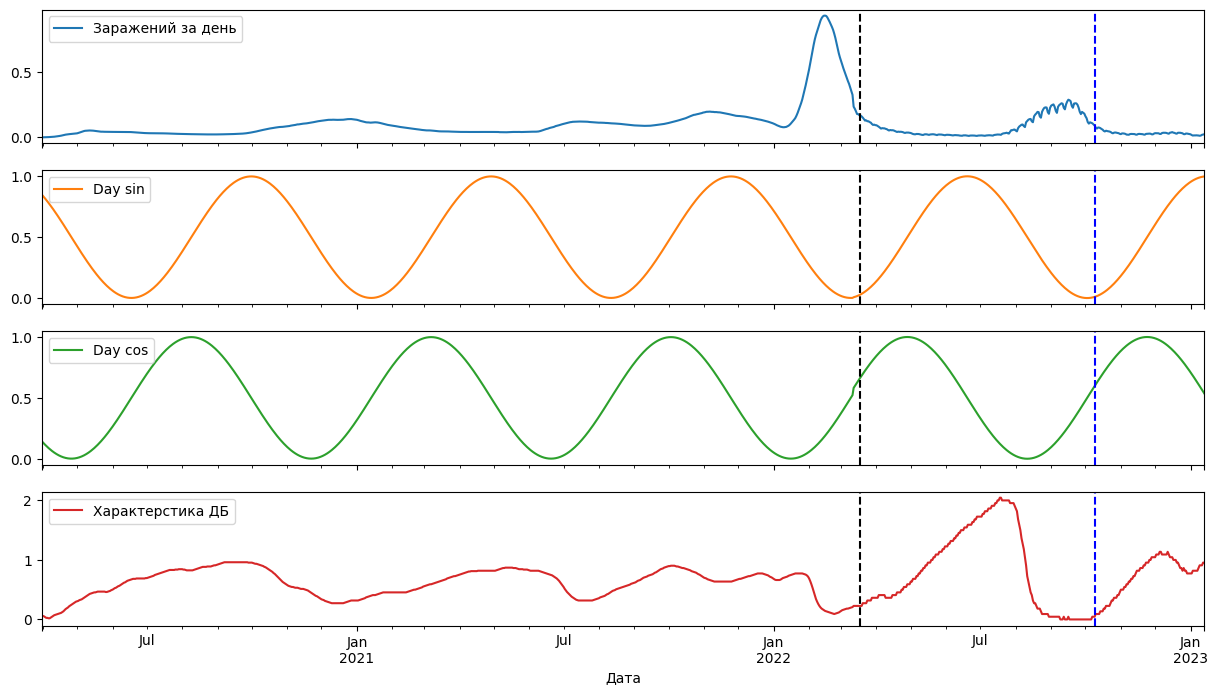

In [ ]:
#@title
class WindowGeneratorAllFeatures():
    def __init__(self, data: pd.DataFrame, conf, mean_flg=False, scaler=StandardScaler()):
        self.data = data
        self.conf = conf
        self.mean_flg = mean_flg
        self.scaler = scaler

    
    def get_standart_data(self):
        data_train = self.data.iloc[:self.conf.train_split, :]
        data_test = self.data.iloc[self.conf.train_split:, :]
        col_name = self.data.columns
        df_train_scaled = pd.DataFrame(self.scaler.fit_transform(data_train), columns=col_name, index=data_train.index) 
        df_test_scaled = pd.DataFrame(self.scaler.transform(data_test), columns=col_name, index=data_test.index)
        if self.mean_flg:
            df_mean = df_train_scaled.iloc[:self.conf.train_split, :].rolling(window=self.conf.window_size_MA).mean()
            df_mean.dropna(inplace=True)
            df_scaled = pd.concat([df_mean, df_test_scaled])
        self.conf.n_samples = df_scaled.shape[0]
        assert self.conf.val_split+self.conf.n_future<=self.conf.n_samples, f'Некорректное разбиение'
        return df_scaled


    def plot_standart_data(self):
        df_scaled = self.get_standart_data()
        ax = df_scaled.plot(subplots=True)
        for ax_i in ax:
            ax_i.axvline(df_scaled.index[self.conf.train_split], color='k', linestyle='--')
            ax_i.axvline(df_scaled.index[self.conf.val_split], color='b', linestyle='--')
        plt.show()


    def _split_series(self, series):
        X, y = list(), list()
        for window_start in range(len(series)):
            past_end = window_start + self.conf.window_size
            future_end = past_end + self.conf.n_future
            if future_end > len(series):
                break
            past, future = series[window_start:past_end, :], series[past_end:future_end, :]
            X.append(past)
            y.append(future)
        return np.array(X), np.array(y)

    
    def get_data_to_model(self):
        df_scaled = self.get_standart_data()
        dataset = df_scaled.values

        X_train, y_train = self._split_series(df_scaled.iloc[:self.conf.train_split, :].values)
        X_val, y_val = self._split_series(df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :].values)
        X_test, y_test = self._split_series(df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :].values)

        return X_train, y_train, X_val, y_val, X_test, y_test

    def get_tensor_data(self):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        BUFFER_SIZE = X_train.shape[0]

        train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE, seed=0).batch(self.conf.batch_size).repeat()

        val_data_multi = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_data_multi = val_data_multi.batch(self.conf.batch_size).repeat()

        return train_data_multi, val_data_multi


    def get_inverse_values(self, y_true, y_pred):
        y_true_inv = self.scaler.inverse_transform(y_true)
        y_pred_inv = self.scaler.inverse_transform(y_pred)
        return y_true_inv, y_pred_inv

    def plot_validation_window(self, model):
        fig, ax = plt.subplots(2,2,figsize=(20,15))
        ax = ax.ravel()
        window_list = [0, 20, 40, 60]
        df_scaled = self.get_standart_data()
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_val = model.predict(X_val, verbose=0)
        df_val = df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :]
        date_val = df_val.index.values
        for ind, val in enumerate(window_list):
            assert X_val.shape[0]-1>=val, f"Окна c номером {val} не существует"
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[val, :, :], pred_val[val, :, :])
            y_based_pred = self.scaler.inverse_transform(X_val[val, :, :])
            ax[ind].plot(date_val[val:val+self.conf.window_size], y_based_pred[:, -1], label='dinamic', color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size+1], y_val_inv[:,-1], 'o', label='Факт.', color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size+1], pred_val_inv[:,-1], 'o', label='Прогноз', color='salmon')
            mape = mean_absolute_percentage_error(y_val_inv[:,-1], pred_val_inv[:,-1])*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)}.')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()

    def plot_test_window(self, model):
        fig, ax = plt.subplots(1,2,figsize=(20,10))
        ax = ax.ravel()
        window_list = [0, 20]
        df_scaled = self.get_standart_data()
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_test = model.predict(X_test, verbose=0)
        df_test = df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :]
        date_test = df_test.index.values
        for ind, val in enumerate(window_list):
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[val, :, :], pred_test[val, :, :])
            y_based_pred = self.scaler.inverse_transform(X_test[val, :, :])
            ax[ind].plot(date_test[val:val+self.conf.window_size], y_based_pred[:, -1], label='dinamic', color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size+1], y_test_inv[:,-1], 'o',  label='Факт.', color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size+1], pred_test_inv[:,-1], 'o', label='Прогноз', color='salmon')
            mape = mean_absolute_percentage_error(y_test_inv[:,-1], pred_test_inv[:,-1])*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)}.')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()

    def calc_validation_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        list_num_wind = np.arange(X_val.shape[0])
        list_metric = []
        pred_val = model.predict(X_val, verbose=0)
        for wind in list_num_wind:
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[wind, :, :], pred_val[wind, :, :])
            mape_e1d1 = mean_absolute_percentage_error(y_val_inv[:, -1], pred_val_inv[:, -1])
            list_metric.append(mape_e1d1*100)
            IPython.display.clear_output()
        return list_metric


    def calc_average_validation_mape(self, model):
        list_metric = self.calc_validation_mape(model)
        return sum(list_metric) / len(list_metric)

    def calc_test_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        list_num_wind = np.arange(X_test.shape[0])
        list_metric = []
        pred_test = model.predict(X_test, verbose=0)
        for wind in list_num_wind:
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[wind, :, :], pred_test[wind, :, :])
            mape_e1d1 = mean_absolute_percentage_error(y_test_inv[:, -1], pred_test_inv[:, -1])
            list_metric.append(mape_e1d1*100)
            IPython.display.clear_output()
        return list_metric

    def calc_average_test_mape(self, model):
        list_metric = self.calc_test_mape(model)
        return sum(list_metric) / len(list_metric)

    def plot_chart_mape_window(self, model):
        fig, ax = plt.subplots(1,2,figsize=(20,8))
        ax = ax.ravel()
        val_mape = self.calc_validation_mape(model)
        test_mape = self.calc_test_mape(model)
        x_val = np.arange(len(val_mape))+1
        x_test = np.arange(len(test_mape))+1
        ax[0].plot(x_val,val_mape)
        ax[0].set_title('Validation data')
        ax[0].set_xlabel('Номер окна')
        ax[0].set_ylabel('MAPE')
        ax[0].grid()

        ax[1].plot(x_test, test_mape)
        ax[1].set_title('Test data')
        ax[1].set_xlabel('Номер окна')
        ax[1].set_ylabel('MAPE')
        ax[1].grid()
        plt.show()

conf = config(df_search)
conf.window_size = 90
conf.patience = 10
conf.batch_size = 32
conf.n_future = 1
w_all_features = WindowGeneratorAllFeatures(df_search, mean_flg=True, scaler=MinMaxScaler(), conf=conf)
w_all_features.plot_standart_data()

In [ ]:
#@title
class attention_encoder(Layer):
    def __init__(self, encoder_num_hidden=128):
        super(attention_encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w_e",
            shape=(2*self.encoder_num_hidden, 1),
            initializer="random_normal",
            trainable=True,
        )
        self.u_e = self.add_weight(
            name="u_e",
            shape=(input_shape[-1]-2*self.encoder_num_hidden, 1), 
            initializer="random_normal", 
            trainable=True
        )
        self.v_e = self.add_weight(
            name="v_e",
            shape=(1, 1), 
            initializer="random_normal", 
            trainable=True
        )

    def call(self, inputs):
        """
        Args:
            inputs: (batch_size*num_features, 2 * encoder_num_hidden + window_size)
        """
        state = inputs[:, :2*self.encoder_num_hidden]
        x_k = inputs[:, 2*self.encoder_num_hidden:]
        e_k = tf.keras.activations.tanh(tf.matmul(state, self.w) + tf.matmul(x_k, self.u_e))
        return tf.matmul(e_k, self.v_e)

In [ ]:
#@title
class attention_decoder(Layer):
    def __init__(self, decoder_num_hidden=128, encoder_num_hidden=128):
        super(attention_decoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w_d",
            shape=(input_shape[-1]-self.encoder_num_hidden, 1),
            initializer="random_normal",
            trainable=True,
        )
        self.u_d = self.add_weight(
            name="u_d",
            shape=(self.encoder_num_hidden, 1), 
            initializer="random_normal", 
            trainable=True
        )
        self.v_d = self.add_weight(
            name="v_d",
            shape=(1, 1), 
            initializer="random_normal", 
            trainable=True
        )

    def call(self, inputs):
        """
        Args:
            inputs: (batch_size*window_size, 2 * decoder_num_hidden + encoder_num_hidden)
        """
        state = inputs[:, :2*self.decoder_num_hidden]
        h_i = inputs[:, 2*self.decoder_num_hidden:]
        l_i =  tf.keras.activations.tanh(tf.matmul(state, self.w) + tf.matmul(h_i, self.u_d))
        return tf.matmul(l_i, self.v_d)

In [ ]:
#@title
tf.config.run_functions_eagerly(True)
class DA_RNN_LSTM_with_custom_attention(tf.keras.Model):
    def __init__(self, conf, encoder_num_hidden, decoder_num_hidden):
        super().__init__()
        self.conf = conf
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.lstm_layer_encoder = tf.keras.layers.LSTMCell(self.encoder_num_hidden)
        self.lstm_layer_decoder = tf.keras.layers.LSTMCell(self.decoder_num_hidden)
        self.encoder_attn = attention_encoder(encoder_num_hidden=self.encoder_num_hidden)
        self.decoder_attn = attention_decoder(decoder_num_hidden=self.decoder_num_hidden, encoder_num_hidden=self.encoder_num_hidden)
        self.fc = Dense(units=self.decoder_num_hidden, activation=None)
        self.fc_final = Dense(units=self.conf.num_features, activation=None)

    def _initialize_hidden_state(self, inputs, num_hidden):
        return [tf.Variable(tf.zeros((inputs.shape[0], num_hidden))), tf.Variable(tf.zeros((inputs.shape[0], num_hidden)))]

    def encoder(self, inputs):
        h_n, s_n = self._initialize_hidden_state(inputs, self.encoder_num_hidden)
        batch_size = inputs.shape[0]
        window_size = inputs.shape[1]
        num_features = inputs.shape[2]

        h_encoded = []

        for t in range(window_size):
            h_n_exp = tf.expand_dims(h_n, axis=0)
            h_n_exp = tf.repeat(h_n_exp, repeats=num_features, axis=0)
            h_n_exp = tf.transpose(h_n_exp, perm=[1, 0, 2])

            s_n_exp = tf.expand_dims(s_n, axis=0)
            s_n_exp = tf.repeat(s_n_exp, repeats=num_features, axis=0)
            s_n_exp = tf.transpose(s_n_exp, perm=[1, 0, 2])

            x_t = tf.transpose(inputs, perm=[0, 2, 1])

            x = tf.concat([h_n_exp, s_n_exp, x_t], axis=2) # => (batch_size, num_features, 2 * encoder_num_hidden + window_size)
            
            x = self.encoder_attn(tf.reshape(x, shape=(-1, 2 * self.encoder_num_hidden + window_size))) # => (batch_size*num_feature, 1)
            alpha = tf.nn.softmax(tf.reshape(x, shape=(-1, num_features)), axis=1) # => (batch_size, num_features)
            x_tilde = alpha * inputs[:,t,:]  # => (batch_size, num_features)

            _, finale_state = self.lstm_layer_encoder(x_tilde, states=[h_n, s_n])
            h_n = finale_state[0]
            s_n = finale_state[1]
            h_encoded.append(h_n)
        
        X_encoded = tf.stack(h_encoded)
        # X_tilde: (batch_size, window_size, num_features)
        return tf.transpose(X_encoded, perm=[1, 0, 2]) # (batch_size, window_size, encoder_num_hidden)
    
    def decoder(self, X_encoded, inputs):
        d_n, c_n = self._initialize_hidden_state(inputs, self.decoder_num_hidden)
        batch_size = inputs.shape[0]
        window_size = inputs.shape[1]
        y_prev = inputs[:, :, -1] # => (batch_size, window_size)

        for t in range(window_size):
            d_n_exp = tf.expand_dims(d_n, axis=0)
            d_n_exp = tf.repeat(d_n_exp, repeats=window_size, axis=0)
            d_n_exp = tf.transpose(d_n_exp, perm=[1, 0, 2])

            c_n_exp = tf.expand_dims(c_n, axis=0)
            c_n_exp = tf.repeat(c_n_exp, repeats=window_size, axis=0)
            c_n_exp = tf.transpose(c_n_exp, perm=[1, 0, 2])

            x = tf.concat(values=[d_n_exp, c_n_exp, X_encoded], axis=2) # => (batch_size, window_size, 2 * decoder_num_hidden + encoder_num_hidden)

            x = self.decoder_attn(tf.reshape(x, shape=(-1, 2*self.decoder_num_hidden+self.encoder_num_hidden))) # => (batch_size*window_size, 1)

            beta = tf.nn.softmax(tf.reshape(x, shape=(-1, window_size)), axis=1) # (batch_size, window_size)
            beta = tf.expand_dims(beta, axis=1) # => (batch_size, 1, window_size)
            context = tf.matmul(beta, X_encoded)[:, 0, :] # => (batch_size, encoder_num_hidden)
        
            y_tilde = self.fc(tf.concat((context, tf.expand_dims(y_prev[:, t], axis=1)), axis=1)) # => (batch_size, encoder_num_hidden)
            _, final_states = self.lstm_layer_decoder(y_tilde, states=[d_n, c_n])

            d_n = final_states[0]
            c_n = final_states[1]

        y_pred = self.fc_final(tf.concat((d_n, context), axis=1)) # => (batch_size, n_future)
        return y_pred


    def call(self, inputs):
        X_encoded = self.encoder(inputs)
        y_pred = self.decoder(X_encoded, inputs)
        y_pred = tf.expand_dims(y_pred, axis=1)
        return y_pred

    def predict_interval(self, inputs, interval):
        batch_size = inputs.shape[0]
        pred = self.predict(inputs)
        predictions = pred
        inputs = tf.concat([inputs[:, 1:self.conf.window_size, :], pred], axis=1)
        for i in range(1, interval):
            pred = self.predict(inputs)
            predictions = tf.concat([predictions, pred], axis=1)
            inputs = tf.concat([inputs[:, 1:self.conf.window_size, :], pred], axis=1)
        
        return predictions[:,:,-1]


In [ ]:
#@title
class WindowGeneratorOneTarget():
    def __init__(self, data: pd.DataFrame, conf, mean_flg=False, scaler=StandardScaler()):
        self.data = data
        self.conf = conf
        self.mean_flg = mean_flg
        self.scaler = scaler

    def get_standart_data(self):
        data_train = self.data.iloc[:self.conf.train_split, :]
        data_test = self.data.iloc[self.conf.train_split:, :]
        col_name = self.data.columns
        df_train_scaled = pd.DataFrame(self.scaler.fit_transform(data_train), columns=col_name, index=data_train.index) 
        df_test_scaled = pd.DataFrame(self.scaler.transform(data_test), columns=col_name, index=data_test.index)
        if self.mean_flg:
            df_mean = df_train_scaled.iloc[:self.conf.train_split, :].rolling(window=self.conf.window_size_MA).mean()
            df_mean.dropna(inplace=True)
            df_scaled = pd.concat([df_mean, df_test_scaled])
        self.conf.n_samples = df_scaled.shape[0]
        # assert self.conf.val_split+self.conf.n_future<=self.conf.n_samples, f'Некорректное разбиение. Отсутствует тестовая выборка'
        return df_scaled


    def plot_standart_data(self):
        df_scaled = self.get_standart_data()
        ax = df_scaled.plot(subplots=True)
        for ax_i in ax:
            ax_i.axvline(df_scaled.index[self.conf.train_split], color='k', linestyle='--')
            ax_i.axvline(df_scaled.index[self.conf.val_split], color='b', linestyle='--')
        plt.show()


    def _split_series(self, series):
        X, y = list(), list()
        for window_start in range(len(series)):
            past_end = window_start + self.conf.window_size
            future_end = past_end + self.conf.n_future
            if future_end > len(series):
                break
            past, future = series[window_start:past_end, :], series[past_end:future_end, -1]
            X.append(past)
            y.append(future)
        return np.array(X), np.array(y)

    
    def get_data_to_model(self):
        df_scaled = self.get_standart_data()
        dataset = df_scaled.values

        X_train, y_train = self._split_series(df_scaled.iloc[:self.conf.train_split, :].values)
        X_val, y_val = self._split_series(df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :].values)
        X_test, y_test = self._split_series(df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :].values)

        return X_train, y_train, X_val, y_val, X_test, y_test

    def get_tensor_data(self):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        BUFFER_SIZE = X_train.shape[0]

        train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE, seed=0).batch(self.conf.batch_size).repeat()

        val_data_multi = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_data_multi = val_data_multi.batch(self.conf.batch_size).repeat()

        return train_data_multi, val_data_multi


    def create_time_steps(self, length):
        return list(range(-length, 0))


    def get_inverse_values(self, y_true, y_pred):
        dummy = pd.DataFrame(np.zeros((len(y_true), self.conf.num_features)))
        dummy.iloc[:, -1] = y_true
        dummy = pd.DataFrame(self.scaler.inverse_transform(dummy))
        y_true_inv = dummy.iloc[:, -1].values
        dummy = pd.DataFrame(np.zeros((len(y_pred), self.conf.num_features)))
        dummy.iloc[:, -1] = y_pred
        dummy = pd.DataFrame(self.scaler.inverse_transform(dummy))
        pred_val_inv = dummy.iloc[:, -1].values
        IPython.display.clear_output()
        return y_true_inv, pred_val_inv

    def plot_validation_window(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        fig, ax = plt.subplots(2,2,figsize=(17,14))
        ax = ax.ravel()
        window_list = [0, 20, 40, 60]
        df_scaled = self.get_standart_data()
        df_val = df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :]
        date_val = df_val.index.values
        pred_val = model.predict_interval(X_val, self.conf.n_future).numpy()
        for ind, val in enumerate(window_list):
            assert X_val.shape[0]-1>=val, f"Окна c номером {val} не существует"
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[val, :], pred_val[val, :])
            y_based_pred = self.scaler.inverse_transform(X_val[val, :, :])
            ax[ind].plot(date_val[val:val+self.conf.window_size], y_based_pred[:, -1], color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], y_val_inv, label='Факт.', color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], pred_val_inv, label='Прогноз', linestyle='--', color='salmon')
            ax[ind].axvline(date_val[val+self.conf.window_size], color='k', linestyle='--')
            ax[ind].axvspan(date_val[val+self.conf.window_size], date_val[val+self.conf.window_size+self.conf.n_future], alpha=0.5, color='lightgray')
            mape = mean_absolute_percentage_error(y_val_inv, pred_val_inv)*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()


    def plot_test_window(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        fig, ax = plt.subplots(1,2,figsize=(17,6))
        ax = ax.ravel()
        window_list = [0, 20]
        df_scaled = self.get_standart_data()
        df_test = df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :]
        date_test = df_test.index.values
        pred_test = model.predict_interval(X_test, self.conf.n_future).numpy()
        for ind, val in enumerate(window_list):
            assert X_test.shape[0]-1>=val, f"Окна с номером {val} не существует"
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[val,:], pred_test[val,:])
            y_based_pred = self.scaler.inverse_transform(X_test[val, :, :])
            ax[ind].plot(date_test[val:val+self.conf.window_size], y_based_pred[:, -1], color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], y_test_inv, label='Факт.', color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], pred_test_inv, label='Прогноз', linestyle='--', color='salmon')
            ax[ind].axvline(date_test[val+self.conf.window_size], color='k', linestyle='--')
            ax[ind].axvspan(date_test[val+self.conf.window_size], date_test[val+self.conf.window_size+self.conf.n_future], alpha=0.5, color='lightgray')
            mape = mean_absolute_percentage_error(y_test_inv, pred_test_inv)*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()

    def calc_validation_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_val = model.predict_interval(X_val, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_val.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[wind, :], pred_val[wind, :])
            mape_e1d1 = mean_absolute_percentage_error(y_val_inv, pred_val_inv)
            list_metric.append(mape_e1d1*100)
        return list_metric

    def calc_average_validation_mape(self, model):
        list_metric = self.calc_validation_mape(model)
        return sum(list_metric) / len(list_metric)

    def calc_validation_r2_score(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_val = model.predict_interval(X_val, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_val.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[wind, :], pred_val[wind, :])
            r2 = r2_score(y_val_inv, pred_val_inv)
            list_metric.append(r2)
        return list_metric

    def calc_median_validation_r2_score(self, model):
        list_metric = self.calc_validation_r2_score(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def calc_median_validation_mape(self, model):
        list_metric = self.calc_validation_mape(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def calc_test_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_test = model.predict_interval(X_test, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_test.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[wind,:], pred_test[wind,:])
            mape_e1d1 = mean_absolute_percentage_error(y_test_inv, pred_test_inv)
            list_metric.append(mape_e1d1*100)
        return list_metric

    def calc_test_r2_score(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_test = model.predict_interval(X_test, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_test.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[wind,:], pred_test[wind,:])
            r2 = r2_score(y_test_inv, pred_test_inv)
            list_metric.append(r2)
        return list_metric

    def calc_median_test_r2_score(self, model):
        list_metric = self.calc_test_r2_score(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def calc_average_test_mape(self, model):
        list_metric = self.calc_test_mape(model)
        return sum(list_metric) / len(list_metric)

    def calc_median_test_mape(self, model):
        list_metric = self.calc_test_mape(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def plot_chart_mape_window(self, model):
        fig, ax = plt.subplots(1,2,figsize=(17,8))
        ax = ax.ravel()
        val_mape = self.calc_validation_mape(model)
        test_mape = self.calc_test_mape(model)
        x_val = np.arange(len(val_mape))+1
        x_test = np.arange(len(test_mape))+1
        ax[0].plot(x_val,val_mape)
        ax[0].set_title('Валидационные данные')
        ax[0].set_xlabel('Номер окна')
        ax[0].set_ylabel('MAPE, %')
        ax[0].grid()

        ax[1].plot(x_test, test_mape)
        ax[1].set_title('Тестовые данные')
        ax[1].set_xlabel('Номер окна')
        ax[1].set_ylabel('MAPE, %')
        ax[1].grid()
        plt.show()

In [ ]:
df_one_waves = df_search.loc[:'2022-02-01', :]
df_one_waves.tail()

,Заражений за день,Day sin,Day cos,Характерстика ДБ
Дата,,,,
2022-01-28,98040,-0.433884,-0.900969,28.0
2022-01-29,113122,-0.460642,-0.887586,28.0
2022-01-30,121228,-0.486989,-0.873408,27.0
2022-01-31,124070,-0.512899,-0.858449,26.0
2022-02-01,125836,-0.538351,-0.842721,24.0


In [ ]:
conf = config(df_one_waves)
w_all_features = WindowGeneratorAllFeatures(df_one_waves, mean_flg=True, scaler=MinMaxScaler(), conf=conf)
w_all_features.plot_standart_data()

In [ ]:
seed_everything(conf.seed)
conf = config(df_one_waves)
conf.window_size = 90
conf.patience = 15
conf.batch_size = 32
conf.n_future = 1
conf.epochs = 300
w_all_features = WindowGeneratorAllFeatures(df_one_waves, mean_flg=True, scaler=MinMaxScaler(), conf=conf)
X_train, y_train, X_val, y_val, X_test, y_test = w_all_features.get_data_to_model()
train_data_multi, val_data_multi = w_all_features.get_tensor_data()
# conf.steps_per_epoch = X_train.shape[0] // conf.batch_size + 1 
# conf.validation_steps = X_val.shape[0] // conf.batch_size + 1
DA_model = DA_RNN_LSTM_with_custom_attention(decoder_num_hidden=64, encoder_num_hidden=64, conf=conf)
early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=conf.patience,
                                        mode='min')
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

DA_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=conf.loss_func, metrics=conf.metrics)

history = DA_model.fit(train_data_multi, epochs=conf.epochs, validation_data=val_data_multi, verbose=1, callbacks=[early_stopping, model_checkpoint_callback], 
                                    steps_per_epoch=conf.steps_per_epoch, validation_steps=conf.validation_steps)
DA_model.load_weights(checkpoint_filepath)

conf.n_future = 20
w_one_target = WindowGeneratorOneTarget(df_one_waves, mean_flg=True, scaler=MinMaxScaler(), conf=conf)

val_mape = w_one_target.calc_average_validation_mape(DA_model)
test_mape = w_one_target.calc_average_test_mape(DA_model)

print(f'Val MAPE {round(val_mape, 2)}; Test MAPE: {round(test_mape,2)}')

Val MAPE 10.89; Test MAPE: 21.24


In [ ]:
class config():
    def __init__(self, data: pd.DataFrame):
        self.n_samples = data.shape[0]
        self.num_features = data.shape[1]
        self.patience = 10
        self.per_train_split = 0.70
        self.per_val_split = 0.96
        self.window_size_MA = 7
        self.season_day = 200
        self.batch_size = 128
        self.epochs = 50
        self.step = 1
        self.train_split = int(self.n_samples*self.per_train_split)
        self.val_split = int(self.n_samples*self.per_val_split)
        self.window_size = 90
        self.n_future = self.val_split-self.train_split
        self.seed = 0
        self.metrics = ['mean_squared_error']
        self.steps_per_epoch = 50
        self.validation_steps = 20
        self.loss_func = tf.keras.losses.MeanSquaredError()

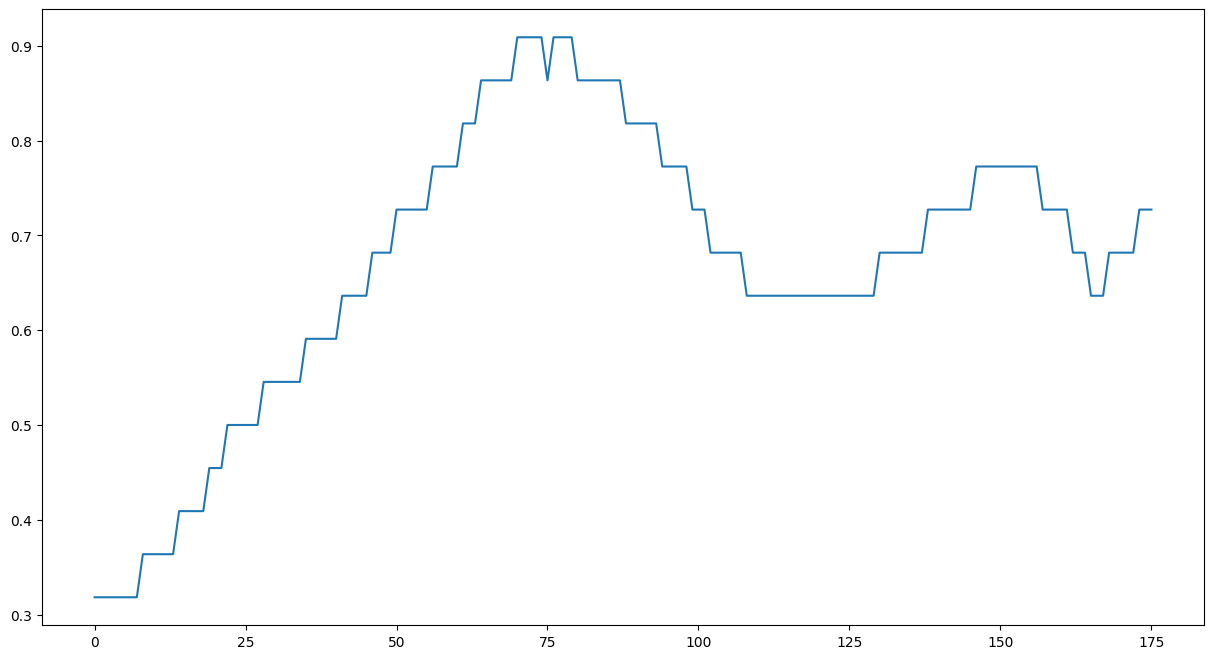

In [ ]:
conf = config(df_one_waves)
w_one_target = WindowGeneratorOneTarget(df_one_waves, mean_flg=True, scaler=MinMaxScaler(), conf=conf)
# w_one_target.plot_standart_data()
X_train, y_train, X_val, y_val, X_test, y_test = w_one_target.get_data_to_model()
plt.plot(y_val[0, :])

In [ ]:
conf = config(df_one_waves)
w_one_target = WindowGeneratorOneTarget(df_one_waves, mean_flg=True, scaler=MinMaxScaler(), conf=conf)

DA_model = DA_RNN_LSTM_with_custom_attention(decoder_num_hidden=64, encoder_num_hidden=64, conf=conf)
early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=conf.patience,
                                        mode='min')
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

DA_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=conf.loss_func, metrics=conf.metrics)

# history = DA_model.fit(train_data_multi, epochs=conf.epochs, validation_data=val_data_multi, verbose=1, callbacks=[early_stopping, model_checkpoint_callback], 
#                                     steps_per_epoch=conf.steps_per_epoch, validation_steps=conf.validation_steps)
DA_model.load_weights(checkpoint_filepath).expect_partial()

val_mape = w_one_target.calc_average_validation_mape(DA_model)
print(f'Val MAPE {round(val_mape, 2)}')

Val MAPE 19.76


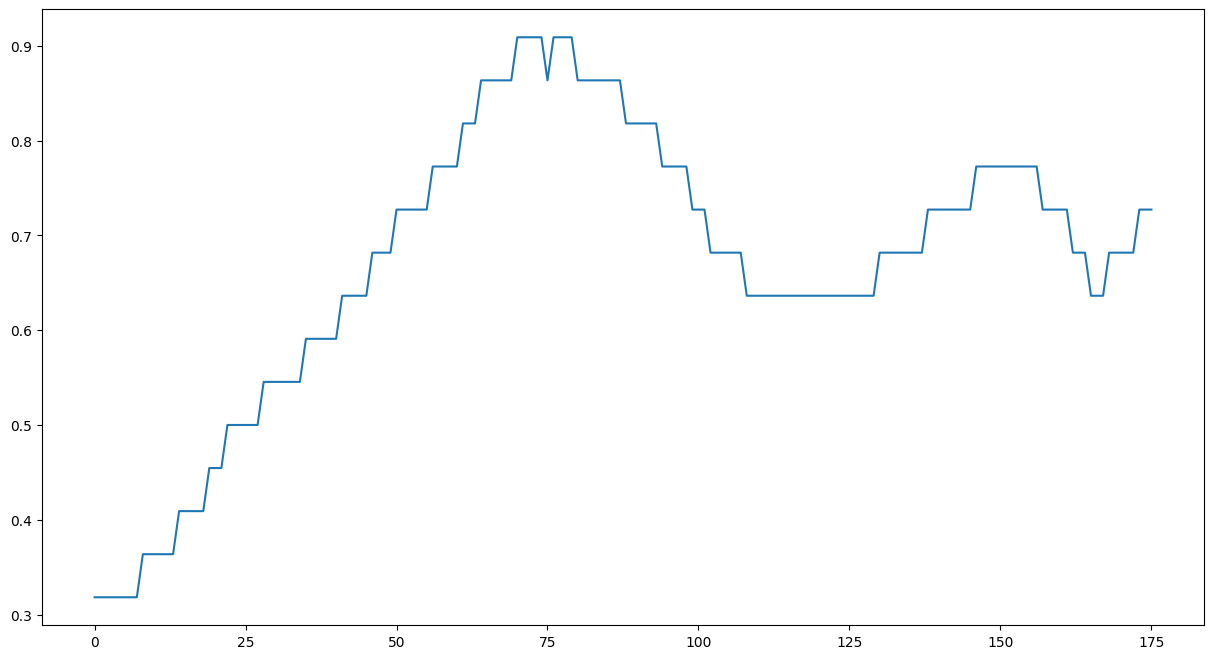

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = w_one_target.get_data_to_model()
plt.plot(y_val[0, :])

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = w_one_target.get_data_to_model()
df_scaled = w_one_target.get_standart_data()
df_val = df_scaled.iloc[w_one_target.conf.train_split-w_one_target.conf.window_size:w_one_target.conf.val_split, :]
date_val = df_val.index.values
pred_val = DA_model.predict_interval(X_val, w_one_target.conf.n_future).numpy()

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


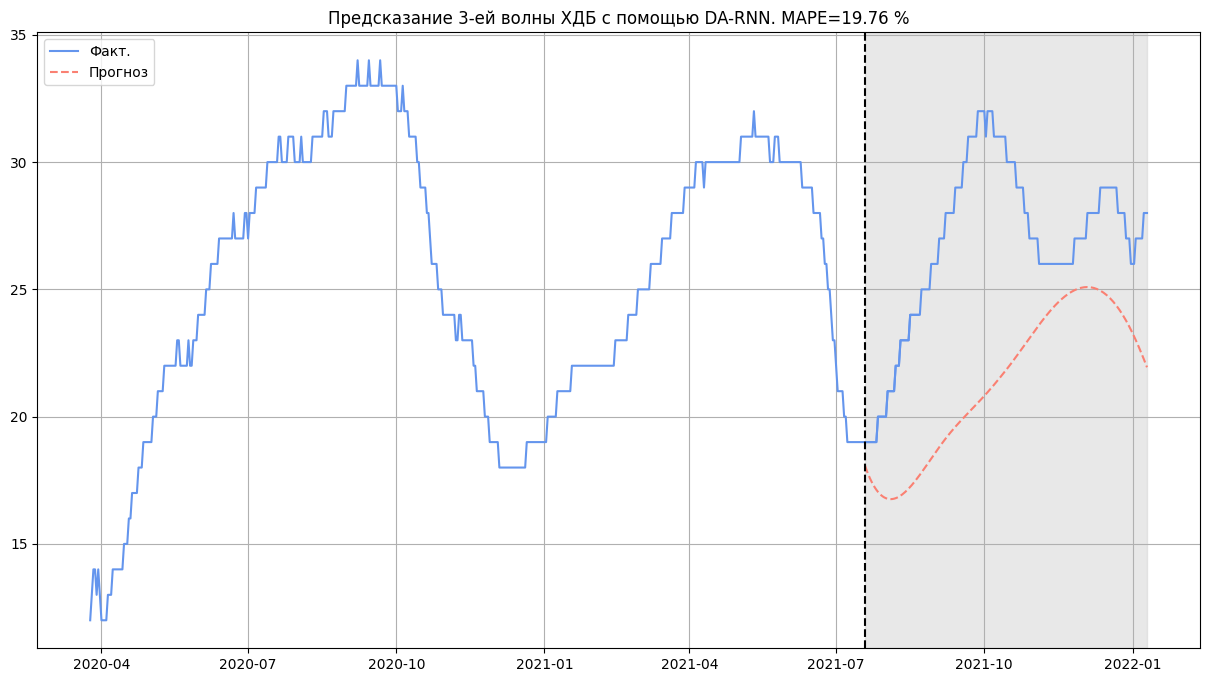

In [ ]:
val = 0
y_val_inv, pred_val_inv = w_one_target.get_inverse_values(y_val[val, :], pred_val[val, :])
y_based_pred = w_one_target.scaler.inverse_transform(X_val[val, :, :])
plt.plot(df_search.index[:w_one_target.conf.train_split+40], df_search.iloc[:w_one_target.conf.train_split+40, -1], color='cornflowerblue')
# plt.plot(date_val[:val+w_one_target.conf.window_size],y_based_pred[:, -1], color='cornflowerblue')
plt.plot(date_val[val+w_one_target.conf.window_size:], y_val_inv, label='Факт.', color='cornflowerblue')
plt.plot(date_val[val+w_one_target.conf.window_size:], pred_val_inv, label='Прогноз', linestyle='--', color='salmon')
plt.axvline(date_val[val+w_one_target.conf.window_size], color='k', linestyle='--')
plt.axvspan(date_val[val+w_one_target.conf.window_size], date_val[-1], alpha=0.5, color='lightgray')
mape = mean_absolute_percentage_error(y_val_inv, pred_val_inv)*100
plt.title(f'Предсказание 3-ей волны ХДБ с помощью DA-RNN. МАРЕ={round(mape,2)} %')
# ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
# ax[ind].tick_params(axis='x', labelrotation = 45)
plt.grid()
plt.legend()

In [ ]:
r2 = r2_score(y_val_inv, pred_val_inv)
r2

-2.560248190768272